# 0. Installing embedding prerequisites

If you use x86 machines or ARM (Mac M1/M2/...) chips with python 3.8, then you may benefit from `spacy` embedding.

In [1]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## 0.a. ARM case 

Probably by the day of your lab the issue is not fixed. Then use `fasttext` of whatever.

In [1]:
!pip install fasttext

In [3]:
import fasttext, fasttext.util
fasttext.util.download_model('en', if_exists='ignore')

'cc.en.300.bin'

In [4]:
ft = fasttext.load_model('cc.en.300.bin')

def embed(text: str):
    return ft.get_sentence_vector(text)

# 00. Index data structure

And now let us install the NMSlib. To avoid M1 crashes please do not use prebuilt wheels.

In [5]:
!pip uninstall nmslib -y
!pip install nmslib --no-binary :all:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 KB 1.5 MB/s eta 0:00:001.5 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 KB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Skipping wheel build for nmslib, due to binaries being disabled for it.
  Created wheel for pybind11: filename=pybind11-2.6.1-py2.py3-none-any.whl size=188526 sha256=25c8649e2d278eed1d06c820b8c5be64273421a02914889ae225cd1135fa4c64
  Stored in directory: /home/thecarrot/.cache/pip/wheels/05/6d/14/25d7698ea031d63f083802c87c7ef546bc2f735631f1daf8a8
Successfully built pybind11
  Attempting uninstall: pybind11
    Found existing installation: pybind11 2.10.4
    Uninstalling pybind11-2.10.4:
      Successfully uninstalled pybind11-2.10.4
  Running setup.py install for nmslib ... done


Check it works:

In [6]:
import nmslib

# Generate some vectors 

Download [Jeopardy dataset](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/JEOPARDY_CSV.zip). Unpack it! Read it as CSV. Embed `Question`s with spacy model.

In [10]:
MAX = 30000
DATASET_FILENAME = 'JEOPARDY_CSV.csv'

In [11]:
import csv
import numpy as np

strings = []

with open(DATASET_FILENAME, 'r', encoding='utf8') as f:
    dr = csv.DictReader(f, delimiter=',')
    for i, line in enumerate(dr):
        if i == MAX: break
        strings.append(line)
        
print("Strings:", len(strings))

Strings: 30000


In [12]:
import tqdm
import pickle
import os

# if vector dimension is different - please change
vectors = np.zeros((MAX, 300))

if os.path.exists('vectors'):
    print("Vectors are precomputed! Loading ...", end='')
    with open('vectors', 'rb') as f:
        vectors = pickle.load(f)
    print(" done")
else:
    print("Vectors are not precomputed. Computing ...", end='')
    for i, line in enumerate(tqdm.tqdm(strings)):
        vectors[i, :] = embed(line['Question'])
    print(" dumping ...", end='')
    with open('vectors', 'wb') as f:
        pickle.dump(vectors, f)
    print(" done")

Vectors are not precomputed. Computing ...

100%|██████████| 30000/30000 [00:24<00:00, 1238.75it/s]


 dumping ... done


In [13]:
print("Vectors:", vectors.shape, "| strings:", len(strings))

Vectors: (30000, 300) | strings: 30000


# 1. Index construction

- index methods: `'nsw'`, `'hnsw'` and [others](https://github.com/nmslib/nmslib/blob/master/manual/methods.md). We will use `hnsw` and `brute_force`.
- space: `'cosinesimil'` and [many others](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md). We will use `cosinesimil`.
- `post` parameters of `createIndex()`: optimization after HNSW built. [Read more here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md#graph-based-search-methods-sw-graph-and-hnsw).
- `ef`: the size of the dynamic list for the nearest neighbors (used during the search). `efConstruction` improves the quality of a constructed graph and leads to higher accuracy of search, also leads to longer indexing times. Typically `ef=100..2000`. Similarly, increasing the value of `efSearch` improves recall at the expense of longer retrieval time.
- `M`: defines the maximum number of neighbors. The reasonable range of values for these parameters is `5..100`.

Here implement `find_for_vector` and `find_for_batch` methods according to the quick start documentation.

In [14]:
import nmslib

def get_index(
        vectors, 
        method='hnsw', 
        space='cosinesimil', 
        postprocessing_optimization_level=2,
        efConstruction=100,
        efSearch=100,
        M=16,
        cutoff=None
):
    import gc
    gc.collect()
    
    if cutoff is not None:
        vectors = vectors[:cutoff]
    
    index = nmslib.init(method=method, space=space, space_params = {
        "efConstruction": efConstruction,
        "efSearch": efSearch,
        "M": M,
    })
    index.addDataPointBatch(vectors)
    if method == 'hnsw':
        # this parameter appies to HNSW only
        index.createIndex({'post': postprocessing_optimization_level}, print_progress=True)
    else:
        index.createIndex(print_progress=True)
    return index


# should return the list of ids, sorted by dist from closest
def find_for_vector(index, vector, nn) -> list:
    # TODO your code here
    ids, dists = index.knnQuery(vector, k=nn)
    return list(ids)


# should return list of lists of indices. Outer list is len(batch), inner lists are `nn`
def find_for_batch(index, batch, nn) -> list:
    # TODO your code here
    result = index.knnQueryBatch(batch, k=nn, num_threads=8)
    return [list(k[0]) for k in result]

## Construct buckets with ground truth

In [15]:
bucket = ['opera', 'math', 'geography', 'films', 'cats', 'zebra', 
          'cooking', 'armory', 'war', 'history', 'money', 'books', 
          'quantum physics', 'snakes', 'sea', 'plants', 'chemistry', 
          'stars', 'science fiction', 'languages', 'clothes']
bucket_vectors = [embed(t) for t in bucket]
bucket += [s['Question'] for s in strings[150:14000:7]]
bucket_vectors += [v for v in vectors[150:14000:7]]
print(len(bucket))

2000


## Let's collect ACCURATE nearest neighbours with flat index (no index)

In [16]:
# dataset sizes
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]

In [17]:
flats = {}
for cutoff in DS:
    flats[cutoff] = get_index(vectors, method='brute_force', cutoff=cutoff)

In [18]:
ground_truth = {}
for cutoff in DS:
    bucket_results = find_for_batch(flats[cutoff], bucket_vectors, nn=1000)
    ground_truth[cutoff] = bucket_results

## Compute recall @N

Implement recall@N computation. Discuss the values.

In [19]:
def recall(sorted_result : list, sorted_ground_truth: list, N: int) -> float:
    # your code here
    a = sorted_result[:N]
    b = sorted_ground_truth[:N]
    return len(set(a).intersection(b)) / N

In [20]:
for b in ground_truth[10000][:5]:
    print(recall(b, b, 700), recall(b[:500], b, 700), recall(b[:350], b, 700), recall([], b, 700))

1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0
1.0 0.7142857142857143 0.5 0.0


Discuss the values.
- Why do you see these numbers? 
- Why are they equal?

# 2. Test HNSW

Create an index with default settings and assess its recall numbers.

In [21]:
hnsw = get_index(vectors, method='hnsw')


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
*********************************************************

In [22]:
vector_id = 5
vector = bucket_vectors[vector_id]
reference = ground_truth[DS[-1]][vector_id]

for n in [100, 1000, 2000]:
    ids = find_for_vector(hnsw, bucket_vectors[5], nn=n)
    print(f"recall@{n} =", recall(ids, ground_truth[DS[-1]][5], n))

recall@100 = 0.4
recall@1000 = 0.138
recall@2000 = 0.069


Discuss: why recall drops with the growth of N?

The recall drops with the growth of N because as N increases, we are considering more neighbors for a query, including more false positives. As the number of neighbors increases, the recall can decrease because there is a higher probability of false positives being included in the neighbors, leading to a higher number of incorrect matches. Therefore, it is more difficult to achieve high recall as N increases.

# 3. Assessment

Let's vary parameters of index to see how it influences the following properties:
- construction time.
- search time (for a bucket in total).
- `recall@100`, `recall@1000`, and `recall@100` for 1000 results.

What do we vary? Dataset size `D`, `M`, and `ef`.

In [23]:
import time

def test(index, bucket_vectors, nn=100):
    start = time.time()
    result = find_for_batch(index, bucket_vectors, nn=nn)
    return time.time() - start, result

In [24]:
from itertools import product
import tqdm
import time

# full combination of parameters for grid search
hypers = list(product(MS, DS, EFS))
result = []

for M, D, ef in tqdm.tqdm(hypers):
    start = time.time()
    
    # todo write here the code to construct index object given provided hyperparameters
    I = get_index(
        vectors, 
        method='hnsw',
        efConstruction=ef,
        efSearch=ef,
        M=M,
        cutoff=D
    )
    build_time = time.time() - start
    
    t100, ids100 = test(I, bucket_vectors, nn=100)
    t1000, ids1000 = test(I, bucket_vectors, nn=1000)
    r100, r1000, r100_ = 0., 0., 0.
    
    for i, r in enumerate(ground_truth[D]):
        r100 += recall(ids100[i], r, 100)
        r1000 += recall(ids1000[i], r, 1000)
        r100_ += recall(ids1000[i], r, 100)
    
    r100 /= len(bucket_results)
    r1000 /= len(bucket_results)
    r100_ /= len(bucket_results) 
    
    result.append(
        [M, D, ef, build_time, t100, t1000, r100, r1000, r100_]
    )

  0%|          | 0/60 [00:00<?, ?it/s]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
**********************************************************
  2%|▏         | 1/60 [00:01<01:09,  1.17s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
  3%|▎         | 2/60 [00:02<01:28,  1.53s/it]
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|-

In [25]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", 
           "search time 1000", "recall@100", "recall@1000", "recall@100*"]
d = {}
for i, h in enumerate(headers):
    d[headers[i]] = [r[i] for r in result]

df = pd.DataFrame(d)
# df.to_pickle('results.pkl')
df

,M,D,ef,build time,search time 100,search time 1000,recall@100,recall@1000,recall@100*
0,8,2000,100,0.594320,0.097290,0.192662,0.885780,0.305024,0.885780
1,8,2000,200,0.978629,0.118660,0.269337,0.888860,0.304188,0.888860
2,8,2000,400,0.594717,0.098171,0.197564,0.886525,0.309511,0.886525
3,8,5000,100,1.863807,0.090056,0.222791,0.833195,0.326068,0.833195
4,8,5000,200,1.413292,0.105570,0.248730,0.836775,0.326930,0.836775
5,8,5000,400,1.385322,0.082430,0.217596,0.834075,0.324215,0.834075
6,8,10000,100,3.367180,0.099254,0.244070,0.805180,0.318136,0.805185
7,8,10000,200,3.250746,0.099947,0.239611,0.805315,0.317084,0.805300
8,8,10000,400,3.654662,0.114682,0.281941,0.802630,0.313582,0.802630
9,8,20000,100,9.711321,0.122335,0.283019,0.772950,0.304482,0.772950


Discuss, how parameters (using the table) affect perfromance?

### * Load results (if needed)

(NB: for some reason `pyplot` does not survive together with `nmslib` in Windows. So you may save we save and load).

In [26]:
import pandas as pd
headers = ["M", "D", "ef", "build time", "search time 100", "search time 1000", "recall@100", "recall@1000", "recall@100*"]
DS = [2000, 5000, 10000, 20000, 30000]
# M values
MS = [8, 16, 32, 64]
# ef values
EFS = [100, 200, 400]
# df = pd.read_pickle('results.pkl')

## Displaying results

Let us display them now!

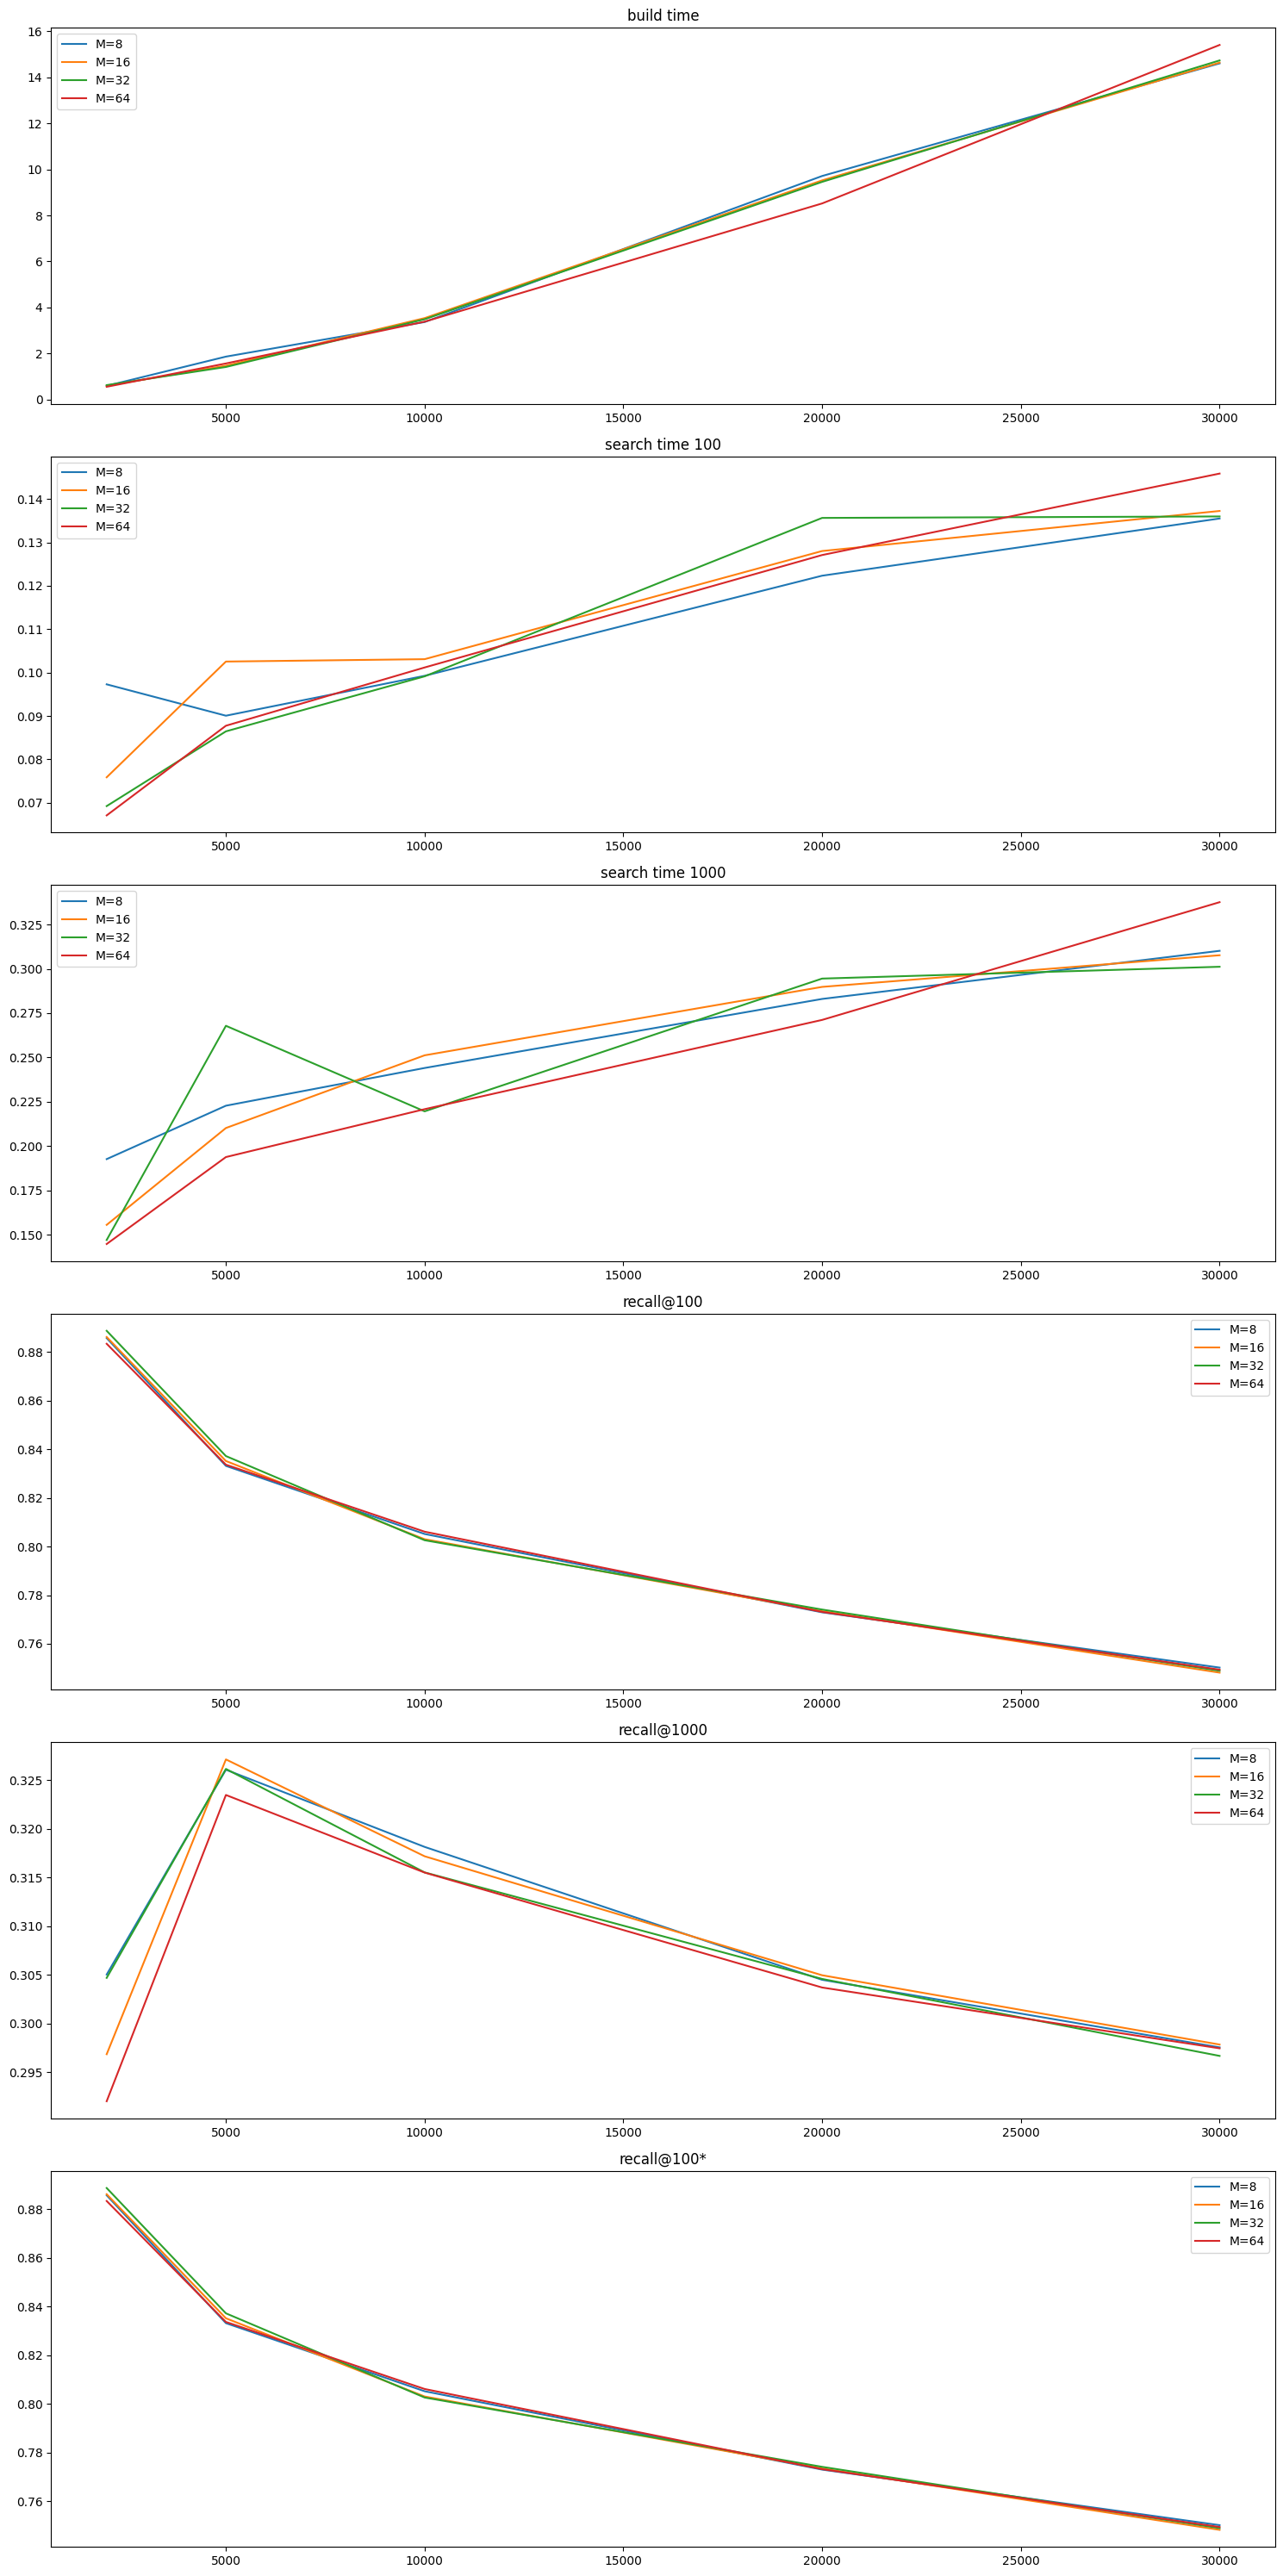

In [27]:
%matplotlib inline 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(headers) - 3, figsize=(15, 30))

for j in range(len(MS)):
    for k in range(3, len(headers)):
        # print(MS[j], k)
        subdata = df[(df['M'] == MS[j]) & (df['ef'] == EFS[0])]
        ax[k-3].plot(subdata['D'], subdata[headers[k]], label=f"M={MS[j]}")
        ax[k-3].set_title(f"{headers[k]}")
        ax[k-3].legend()
        
plt.tight_layout()
plt.show()